In [1]:
# ===============================
# 0) Imports & Config
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# ===============================
# 1) Load minute-level data & set datetime index
# ===============================
# Kaggle path
df_min = pd.read_csv('/kaggle/input/btcusd/btcusd_1-min_data.csv')
df_min['Timestamp'] = pd.to_datetime(df_min['Timestamp'], unit='s')
df_min.set_index('Timestamp', inplace=True)
df_min = df_min.sort_index()

[Minute] Missing timestamps count: 1160
First 10 missing minutes:
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


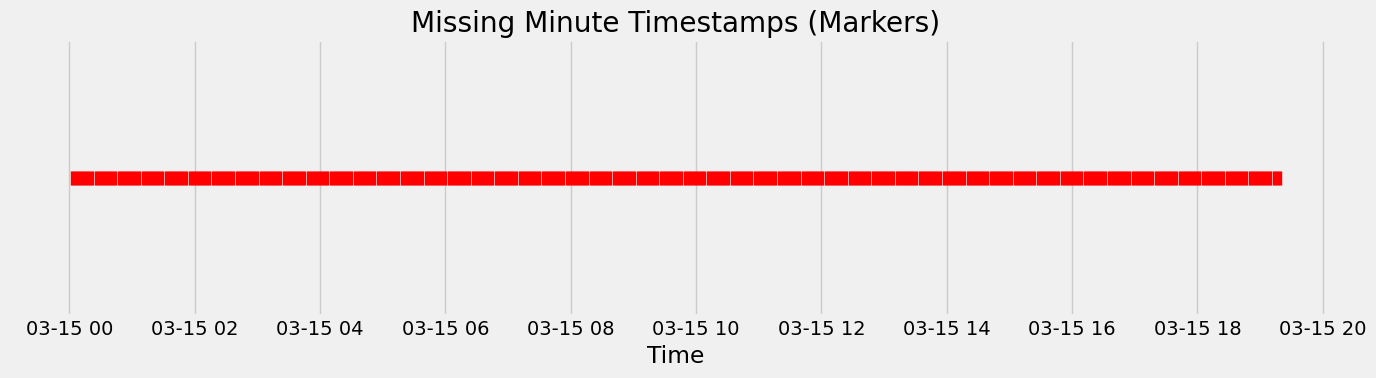

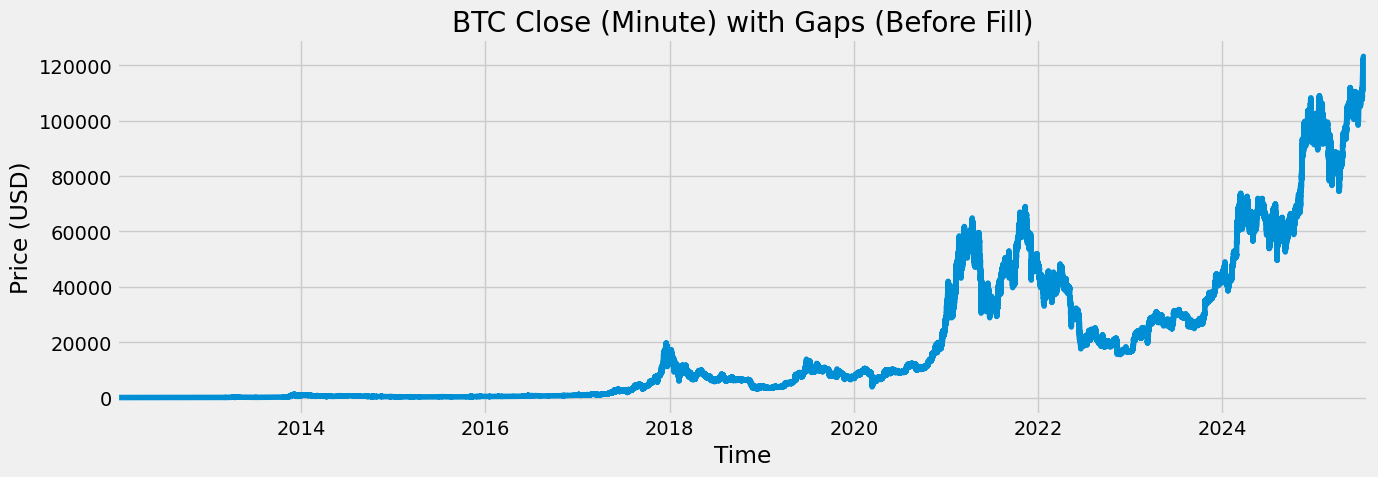

[Minute] Missing after ffill: 0


In [4]:
# ===============================
# 2) Minute-level gap check, visualize, reindex, and forward-fill
# ===============================
# Build full minute index over the data span
full_range_min = pd.date_range(start=df_min.index.min(), end=df_min.index.max(), freq='1min')
missing_min = full_range_min.difference(df_min.index)
print(f"[Minute] Missing timestamps count: {len(missing_min)}")
if len(missing_min) > 0:
    print("First 10 missing minutes:")
    print(missing_min[:10])
    # Visualize missing minutes as vertical markers
    miss_df = pd.DataFrame(index=missing_min)
    miss_df['Missing'] = 1
    plt.figure(figsize=(14, 4))
    plt.plot(miss_df.index, miss_df['Missing'], '|', color='red', markersize=10)
    plt.title("Missing Minute Timestamps (Markers)")
    plt.xlabel("Time")
    plt.yticks([])
    plt.tight_layout()
    plt.show()
else:
    print("No missing minute timestamps found.")

# Reindex to include all minutes (NaNs will appear for missing rows)
df_min_full = df_min.reindex(full_range_min)

# Plot Close with gaps (before filling)
plt.figure(figsize=(14, 5))
df_min_full['Close'].plot(title="BTC Close (Minute) with Gaps (Before Fill)")
plt.xlabel("Time"); plt.ylabel("Price (USD)")
plt.tight_layout(); plt.show()

# Forward-fill minute-level data
df_min_filled = df_min_full.ffill()

# Verify completeness
final_range = pd.date_range(start=df_min_filled.index.min(), end=df_min_filled.index.max(), freq='1min')
final_missing = final_range.difference(df_min_filled.index)
print(f"[Minute] Missing after ffill: {len(final_missing)}")


[Hourly] Missing summary (before fill):
        Missing Values  Percentage
Open                 0         0.0
High                 0         0.0
Low                  0         0.0
Close                0         0.0
Volume               0         0.0


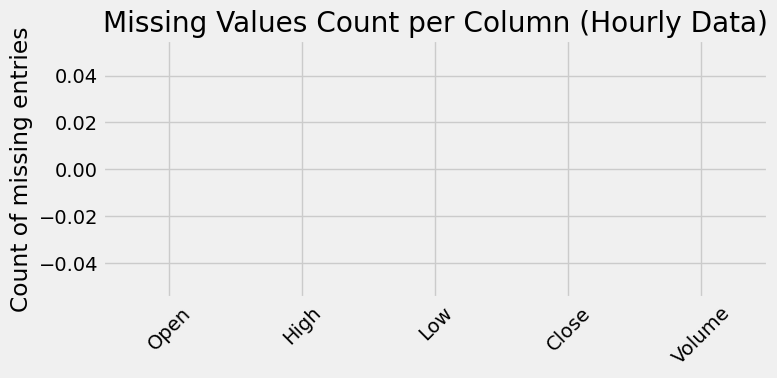

Any remaining NaNs after hourly ffill: False

Descriptive statistics (Hourly, after ffill):
                Open           High            Low          Close  \
count  119055.000000  119055.000000  119055.000000  119055.000000   
mean    19083.056691   19163.407667   18998.286803   19083.977316   
std     26800.959818   26897.866124   26700.870406   26802.195184   
min         4.140000       4.170000       3.800000       4.140000   
25%       432.000000     433.815000     430.015000     432.000000   
50%      6879.030000    6920.000000    6840.560000    6879.310000   
75%     29078.000000   29163.075000   28998.500000   29077.100000   
max    122731.000000  123236.000000  122326.000000  122732.000000   

              Volume  
count  119055.000000  
mean      313.112342  
std       570.141831  
min         0.000000  
25%        49.454435  
50%       141.356935  
75%       349.314954  
max     20551.251040  


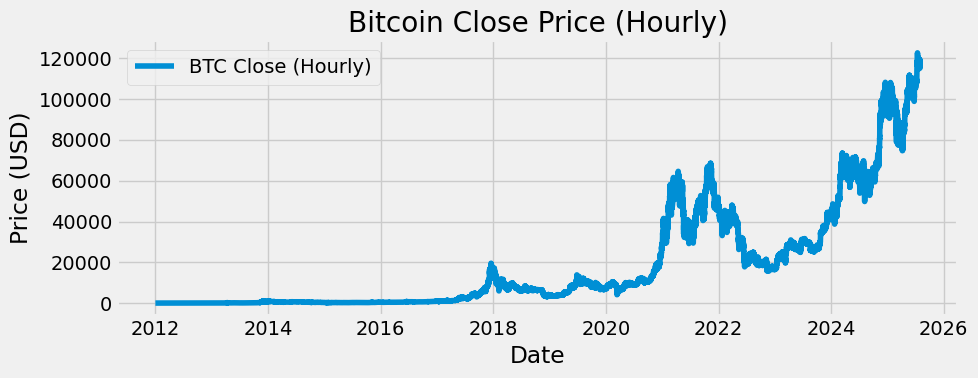

In [5]:
# ===============================
# 3) Resample to hourly & hourly-level QC
# ===============================
# Apply standard OHLC aggregation and sum Volume
df_hourly = df_min_filled.resample('h').agg({
    'Open': 'first',
    'High': 'max',
    'Low' : 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# Hourly missing summary table (before fill)
missing_count = df_hourly.isnull().sum()
missing_percent = 100 * df_hourly.isnull().mean()
missing_table = pd.concat([missing_count, missing_percent], axis=1)
missing_table.columns = ['Missing Values', 'Percentage']
print("\n[Hourly] Missing summary (before fill):")
print(missing_table)

# Visualize hourly missing per column
plt.figure(figsize=(8, 4))
missing_count.plot(kind='bar', rot=45)
plt.title('Missing Values Count per Column (Hourly Data)')
plt.ylabel('Count of missing entries')
plt.tight_layout(); plt.show()

# Forward-fill hourly data
df_hourly_ffill = df_hourly.ffill()

print('Any remaining NaNs after hourly ffill:', df_hourly_ffill.isnull().any().any())
print("\nDescriptive statistics (Hourly, after ffill):")
print(df_hourly_ffill.describe())

# Plot hourly Close
plt.figure(figsize=(10, 4))
plt.plot(df_hourly_ffill.index, df_hourly_ffill['Close'], label='BTC Close (Hourly)')
plt.title('Bitcoin Close Price (Hourly)')
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend(); plt.tight_layout(); plt.show()

In [6]:
# ===============================
# 4) Feature Engineering (Hourly)
#    Use ONLY past information (no leakage)
# ===============================
df_feat = df_hourly_ffill.copy()

# Time features
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['month'] = df_feat.index.month

# Lags (hours)
df_feat['Close_lag1']  = df_feat['Close'].shift(1)
df_feat['Close_lag3']  = df_feat['Close'].shift(3)
df_feat['Close_lag6']  = df_feat['Close'].shift(6)
df_feat['Close_lag24'] = df_feat['Close'].shift(24)  # one day lag (hourly)

df_feat['Vol_lag1'] = df_feat['Volume'].shift(1)

# Rolling stats computed on lagged series to avoid leakage
df_feat['ma_6']  = df_feat['Close_lag1'].rolling(window=6).mean()
df_feat['ma_12'] = df_feat['Close_lag1'].rolling(window=12).mean()
df_feat['ma_24'] = df_feat['Close_lag1'].rolling(window=24).mean()
df_feat['std_6'] = df_feat['Close_lag1'].rolling(window=6).std()
df_feat['std_12'] = df_feat['Close_lag1'].rolling(window=12).std()

# Volatility & returns
df_feat['range_hl'] = df_feat['High'] - df_feat['Low']
df_feat['ret_1']  = df_feat['Close'].pct_change(1)
df_feat['ret_6']  = df_feat['Close'].pct_change(6)
df_feat['ret_24'] = df_feat['Close'].pct_change(24)

# Drop rows with NaNs created by lags/rolling
df_feat = df_feat.dropna()

In [7]:
# ===============================
# 5) Build feature matrix and target  
# ===============================
feature_cols = [
    'Open','High','Low','Volume',
    'hour','dayofweek','month',
    'Close_lag1','Close_lag3','Close_lag6','Close_lag24',
    'Vol_lag1',
    'ma_6','ma_12','ma_24','std_6','std_12',
    'range_hl','ret_1','ret_6','ret_24'
]
df_model = df_feat[feature_cols + ['Close']].copy()
target_col = 'Close'

In [8]:
# ===============================
# 6) Time-based split: Train / Valid / Test
#    Use the last N days as test, previous M days as valid
# ===============================
TEST_DAYS = 60     # last 60 days for test
VALID_DAYS = 60    # last 60 days (before test) for validation

end_time = df_model.index.max()
test_start = end_time - pd.Timedelta(days=TEST_DAYS) + pd.Timedelta(hours=1)
valid_end = test_start - pd.Timedelta(hours=1)
valid_start = valid_end - pd.Timedelta(days=VALID_DAYS) + pd.Timedelta(hours=1)

train_df = df_model[df_model.index <= valid_start - pd.Timedelta(hours=1)]
valid_df = df_model[(df_model.index >= valid_start) & (df_model.index <= valid_end)]
test_df  = df_model[df_model.index >= test_start]

X_train, y_train = train_df[feature_cols].values, train_df[target_col].values
X_valid, y_valid = valid_df[feature_cols].values, valid_df[target_col].values
X_test,  y_test  = test_df[feature_cols].values,  test_df[target_col].values

print("\nSplit ranges:")
print("Train:", train_df.index.min(), "->", train_df.index.max(), "|", X_train.shape)
print("Valid:", valid_df.index.min(), "->", valid_df.index.max(), "|", X_valid.shape)
print("Test :", test_df.index.min(),  "->", test_df.index.max(),  "|", X_test.shape)


Split ranges:
Train: 2012-01-02 10:00:00 -> 2025-04-03 00:00:00 | (116151, 21)
Valid: 2025-04-03 01:00:00 -> 2025-06-02 00:00:00 | (1440, 21)
Test : 2025-06-02 01:00:00 -> 2025-08-01 00:00:00 | (1440, 21)


In [9]:
# ===============================
# 7) Train XGBoost (baseline params)
# ===============================
reg = xgb.XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    tree_method='hist'
)
reg.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# ===============================
# 8) Predict & Evaluate
# ===============================
def evaluate_split(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{name}  MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")

y_pred_train = reg.predict(X_train)
y_pred_valid = reg.predict(X_valid)
y_pred_test  = reg.predict(X_test)

print("\nPerformance:")
evaluate_split("Train", y_train, y_pred_train)
evaluate_split("Valid", y_valid, y_pred_valid)
evaluate_split("Test ", y_test,  y_pred_test)


Performance:
Train  MAE: 45.4099 | RMSE: 89.1512 | R2: 1.0000
Valid  MAE: 1267.5839 | RMSE: 2067.4757 | R2: 0.9563
Test   MAE: 6615.6858 | RMSE: 8707.9156 | R2: -1.1575


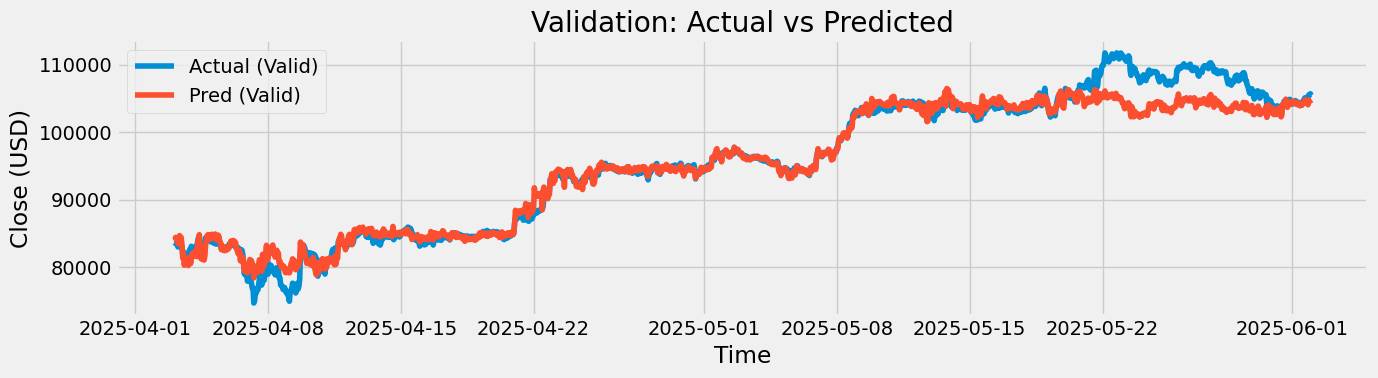

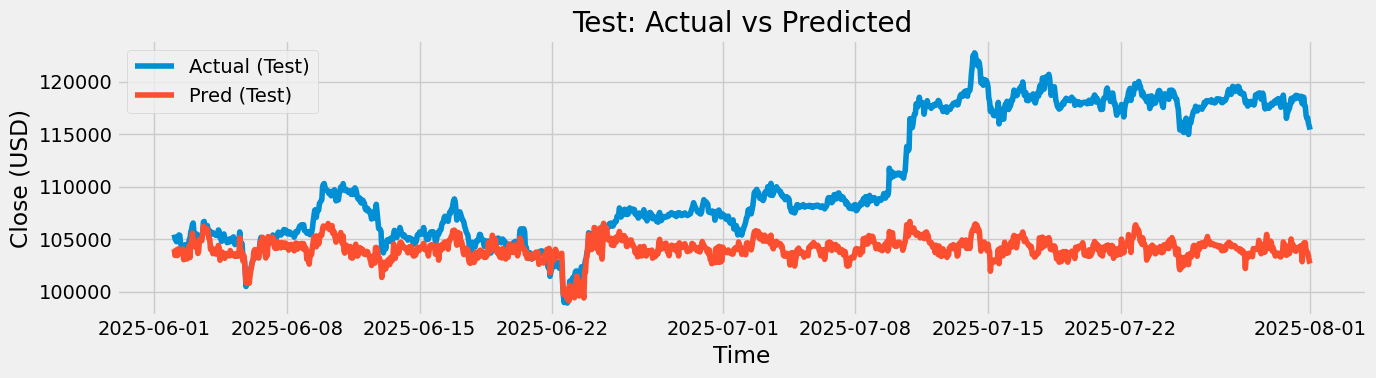

In [11]:
# ===============================
# 9) Visualization
# ===============================
plt.figure(figsize=(14, 4))
plt.plot(valid_df.index, y_valid, label='Actual (Valid)')
plt.plot(valid_df.index, y_pred_valid, label='Pred (Valid)')
plt.title('Validation: Actual vs Predicted')
plt.xlabel('Time'); plt.ylabel('Close (USD)')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(14, 4))
plt.plot(test_df.index, y_test, label='Actual (Test)')
plt.plot(test_df.index, y_pred_test, label='Pred (Test)')
plt.title('Test: Actual vs Predicted')
plt.xlabel('Time'); plt.ylabel('Close (USD)')
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# ===============================
# 10)  Quick Hyperparam Search
# ===============================
param_grid = {
     "learning_rate": [0.03, 0.05, 0.07],
     "max_depth": [4, 6, 8],
     "n_estimators": [400, 800, 1200],
     "subsample": [0.7, 0.8, 0.9],
     "colsample_bytree": [0.7, 0.8, 0.9]
}
search = RandomizedSearchCV(
     estimator=xgb.XGBRegressor(
         objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='hist'
     ),
     param_distributions=param_grid,
     n_iter=12, cv=3, verbose=1, n_jobs=-1
)
search.fit(X_train, y_train)
print("Best params:", search.best_params_)
best_model = search.best_estimator_
y_pred_valid_best = best_model.predict(X_valid)
y_pred_test_best  = best_model.predict(X_test)
evaluate_split("Valid (best)", y_valid, y_pred_valid_best)
evaluate_split("Test  (best)", y_test,  y_pred_test_best)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
